In [14]:
!python --version

Python 3.11.11


In [15]:
import pandas as pd
import numpy as np

from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
from dateutil.parser import parse

# from sklearn.preprocessing import MultiLabelBinarizer, TargetEncoder, OneHotEncoder, StandardScaler, QuantileTransformer
# from matplotlib import pyplot as plt
# import seaborn as sns

In [ ]:
df = pd.read_csv('./movie_dataset.csv', index_col=0)
df = df.drop(columns=['id', 'imdb_id', 'tagline', 'overview', 'vote_average', 'vote_count', 'domestic_opening', 'original_title', 'title', 'spoken_languages'])

df['budget'] = df['budget'].replace({0: np.NAN})
df['revenue'] = df['revenue'].replace({0: np.NAN})
df['runtime'] = df['runtime'].replace({0: np.NAN})

df.dropna(inplace=True)

df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

def get_class(row):
  R = row['revenue']
  B = row['budget']
  if R < B:
    return 0
  elif B <= R < 2*B:
    return 1
  elif 2*B <= R < 4*B:
    return 2
  elif 4*B <= R:
    return 3
  return np.NAN

literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(df['genres'])
classes = ['genre_' + x.replace(' ', '_').lower() for x in mlb.classes_]
df = df.join(pd.DataFrame(dum.astype(bool), df.index, classes))

genres = set(mlb.classes_)

df = df.drop(columns=['genres'], axis=1)

df['original_language'] = df.apply(lambda row: 1 if row['original_language'] == 'en' else 0, axis=1)

def cumulative_revenue_replacer(column, iterable=True):
  entities = df[column].explode().tolist()
  entities_revenue = {}
  for e in entities:
    entities_revenue[e] = 0

  for index, row in df.iterrows():
    if iterable:
      for e in row[column]:
        entities_revenue[e] += row['revenue']
    else:
      entities_revenue[row[column]] += row['revenue']

  def entity_to_cumulative_revenue(entity):
    return entities_revenue[entity]

  def f(row):
    if iterable:
      return sum(list(map(entity_to_cumulative_revenue, row[column])))
    else:
      return entities_revenue[row[column]]

  return f

df['production_companies'] = df.apply(cumulative_revenue_replacer('production_companies'), axis=1)

df['production_countries'] = df.apply(cumulative_revenue_replacer('production_countries'), axis=1)

m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

df['domestic_distributor'] = df.apply(cumulative_revenue_replacer('domestic_distributor', iterable=False), axis=1)

to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)
df['actor_1'] = df.apply(cumulative_revenue_replacer('actor_1', iterable=False), axis=1)
df['actor_2'] = df.apply(cumulative_revenue_replacer('actor_2', iterable=False), axis=1)
df['actor_3'] = df.apply(cumulative_revenue_replacer('actor_3', iterable=False), axis=1)

df['director'] = df.apply(cumulative_revenue_replacer('director', iterable=False), axis=1)

# -----

df['target'] = df.apply(get_class, axis=1)
df = df.drop(columns=['revenue'])

Количество жанров: 19
Жанры:  {'Action', 'Foreign', 'History', 'Horror', 'Romance', 'Mystery', 'Music', 'Comedy', 'Family', 'Documentary', 'War', 'Animation', 'Drama', 'Thriller', 'Fantasy', 'Crime', 'Western', 'Adventure', 'Science Fiction'}


In [31]:
df.shape

(4263, 32)

In [17]:
y = df['target']
X = df.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [18]:
train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
train_data.head()

,original_language,production_companies,production_countries,runtime,domestic_distributor,mpaa,budget,director,genre_action,genre_adventure,...,genre_romance,genre_science_fiction,genre_thriller,genre_war,genre_western,release_month,actor_1,actor_2,actor_3,target
7918,1,3688644408,433069658589,84.0,803339669,R,9000000.0,30075437,False,False,...,False,False,True,False,False,12,21510851,21510851,21510851,2
11025,1,5627539560,415507739043,109.0,4557812905,R,35000000.0,377856988,False,False,...,True,False,False,False,False,7,324414361,1617539248,230938181,3
10921,1,2597977477,415507739043,105.0,3719797617,R,3200000.0,11149137,False,False,...,True,False,False,False,False,9,1996080466,774186320,9060672,1
10423,1,41750973561,415507739043,116.0,38792077507,R,25000000.0,794458936,False,False,...,False,False,False,False,False,12,4000164188,273309540,471129148,2
6213,1,3486042389,415507739043,103.0,13873069752,R,1200000.0,2546451512,False,False,...,False,False,False,False,False,10,153260820,1022290220,104689092,3


In [19]:
label = 'target'
predictor = TabularPredictor(label=label).fit(train_data, presets='medium_quality', time_limit=60)

No path specified. Models will be saved in: "AutogluonModels/ag-20241209_185057"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #136~20.04.1-Ubuntu SMP Thu Nov 14 16:38:05 UTC 2024
CPU Count:          16
Memory Avail:       8.14 GB / 14.95 GB (54.5%)
Disk Space Avail:   16.76 GB / 216.73 GB (7.7%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "/home/mur/Study/25h1/Diploma/AutogluonModels/ag-20241209_185057"
Train Data Rows:    3410
Train Data Columns: 31
Label Column:       target
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	4 unique label values:  [2, 3, 1, 0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter durin

In [20]:
predictor.model_best

'WeightedEnsemble_L2'

In [21]:
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

17371    2
17091    2
7541     0
11777    3
187      0
Name: target, dtype: int64

In [22]:
predictor.evaluate(test_data, silent=True)

{'accuracy': 0.6858147713950762,
 'balanced_accuracy': 0.6597453280642935,
 'mcc': 0.5760377652065077}

In [23]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.689332,0.712575,accuracy,0.056943,0.010751,1.188697,0.056943,0.010751,1.188697,1,True,11
1,WeightedEnsemble_L2,0.685815,0.752495,accuracy,0.428441,0.323010,22.195951,0.003430,0.000646,0.081419,2,True,14
2,LightGBMLarge,0.677608,0.732535,accuracy,0.076360,0.028169,6.638297,0.076360,0.028169,6.638297,1,True,13
3,LightGBM,0.672919,0.718563,accuracy,0.010793,0.004783,1.457139,0.010793,0.004783,1.457139,1,True,5
4,CatBoost,0.652989,0.700599,accuracy,0.012901,0.003542,8.071260,0.012901,0.003542,8.071260,1,True,8
5,NeuralNetTorch,0.640094,0.698603,accuracy,0.020165,0.009452,13.296343,0.020165,0.009452,13.296343,1,True,12
6,LightGBMXT,0.634232,0.680639,accuracy,0.031143,0.011423,1.795684,0.031143,0.011423,1.795684,1,True,4
7,RandomForestEntr,0.634232,0.674651,accuracy,0.186707,0.128788,0.941010,0.186707,0.128788,0.941010,1,True,7
8,RandomForestGini,0.616647,0.676647,accuracy,0.123925,0.136636,1.045200,0.123925,0.136636,1.045200,1,True,6
9,ExtraTreesGini,0.505275,0.562874,accuracy,0.174133,0.128293,1.120661,0.174133,0.128293,1.120661,1,True,9


In [24]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 31 features using 853 rows with 5 shuffle sets...
	73.84s	= Expected runtime (14.77s per shuffle set)
	10.62s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
budget,0.256741,0.012183,6.066658e-07,5,0.281826,0.231655
actor_3,0.163892,0.007198,4.453681e-07,5,0.178713,0.149071
director,0.130129,0.009982,4.122548e-06,5,0.150682,0.109576
actor_2,0.112075,0.009899,7.228109e-06,5,0.132457,0.091693
actor_1,0.098476,0.009560,1.052615e-05,5,0.118160,0.078792
domestic_distributor,0.018288,0.007349,2.554455e-03,5,0.033421,0.003156
genre_crime,0.008675,0.003167,1.800512e-03,5,0.015197,0.002153
production_countries,0.006800,0.004178,1.098967e-02,5,0.015402,-0.001803
mpaa,0.006565,0.004733,1.808331e-02,5,0.016311,-0.003180
genre_history,0.006096,0.000981,7.771776e-05,5,0.008116,0.004077


In [25]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  multiclass
AutoGluon identified the following types of features:
('category', [])  :  1 | ['mpaa']
('float', [])     :  2 | ['runtime', 'budget']
('int', [])       :  8 | ['production_companies', 'production_countries', 'domestic_distributor', 'director', 'release_month', ...]
('int', ['bool']) : 20 | ['original_language', 'genre_action', 'genre_adventure', 'genre_animation', 'genre_comedy', ...]


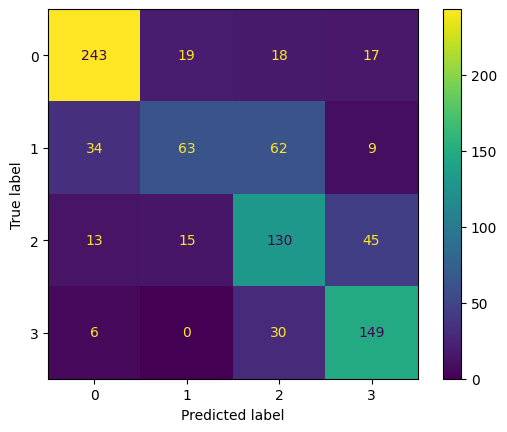

In [26]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred)).plot()

In [27]:
# nn_y_pred = predictor.predict(test_data, model='NeuralNetTorch_r22_BAG_L1')

In [28]:
# cm = metrics.confusion_matrix(y_test, nn_y_pred)
# metrics.ConfusionMatrixDisplay(cm).plot()

In [29]:
def get_1_class_away_accuracy(cm):
    n = len(cm)
    res = (cm[0][0] + cm[0][1]) + (cm[n-1][n-1] + cm[n-1][n-2])
    for i in range(1, n-1):
        res += (cm[i][i-1] + cm[i][i] + cm[i][i+1])
    return res / sum(sum(cm))

In [30]:
cm = metrics.confusion_matrix(y_test, y_pred)
get_1_class_away_accuracy(cm)

0.9261430246189918